# Compare slit profile with reference profile

First try it out by hand for a single slit

In [1]:
from pathlib import Path
import yaml
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import seaborn as sns

import mes_longslit as mes


In [2]:
dpath = Path.cwd().parent / "data"

List of data for each Ha slit exposure:

In [3]:
slit_db_list = yaml.safe_load(
    (dpath / "slits-ha.yml").read_text()
)

Photometric reference image:

In [4]:
photom, = fits.open(dpath / "regrid" / "ha-imslit-median.fits")
wphot = WCS(photom.header)

To start off with, we will analyze a single slit:

In [5]:
db = slit_db_list[0]
db

{'slit_id': 'N10036',
 'orig_file': 'crN10036_bx.fits',
 'image_id': 'N10035',
 'line_id': 'Ha',
 'slit_width': 70,
 'comment': 'Just E of center.'}

Get the HDUs for both the slit spectrum and the image+slit. The spectrum file names are very variable, so we have an `orig_file` entry in the database:

In [41]:
spec_hdu, = fits.open(dpath / "originals" / db["orig_file"])

But the image file names are more regular and can be derived from the `image_id` entry:

In [42]:
im_hdu, = fits.open(dpath / "wcs" / f"cr{db['image_id']}_b-wcs.fits")

There is no sign of any saturated pixels in any of the exposures, so we can miss out that step.

Add in extra fields to database:

- `wa` wavelength axis (1 or 2, fits order) in PV spectrum
- `ij` slit orientation in I+S (1=vertical, 2=horizontal)

In [43]:
if db["slit_id"].startswith("N"):
    db["wa"] = 2
    db["ij"] = 2
else:
    db["wa"] = 1
    db["ij"] = 1
db["s"] = 1

In [44]:
spec_hdu.data = mes.subtract_sky_and_trim(
    spec_hdu.data, db, trim=15, margin=150, degree=1)

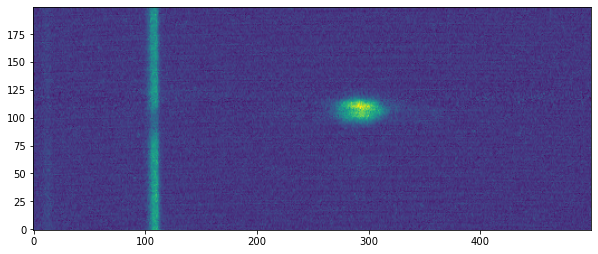

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(spec_hdu.data[250:450, 200:700], origin="lower");
#ax.imshow(spec_hdu.data[:, :], vmin=-3, vmax=3, origin="lower");

So that does a reasonably good job of subtracting the background emission line

Lines to avoid when calculating the continuum

In [11]:
restwavs = {'ha': 6562.79, 'nii': 6583.45, 'nii_s': 6548.05}

In [12]:
spec_profile = mes.extract_full_profile_from_pv(
    spec_hdu,
    wavaxis=db["wa"],
    bandwidth=90.0,
    linedict=restwavs,
)

This is the position of the slit in pixel coordinates.

In [13]:
db["islit"] = 442

In [14]:
imslit_profile = mes.extract_slit_profile_from_imslit(
    im_hdu.data, db, slit_width=2,
)

442


In [15]:
jslit = np.arange(len(spec_profile))


In [16]:
spec_profile.shape, imslit_profile.shape

((998,), (998,))

### Find a better way to do the alignment

In [17]:
jwin_slice = slice(340, 700)
shift_guess = 100
jwin_slice_shift = slice(
    jwin_slice.start - shift_guess, 
    jwin_slice.stop - shift_guess,
)

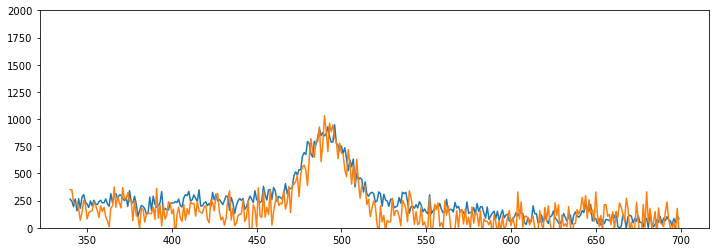

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit[jwin_slice], (imslit_profile[jwin_slice_shift] + 20) * 10)
ax.plot(jslit[jwin_slice], spec_profile[jwin_slice])
ax.set(yscale="linear", ylim=[0, 2000]);



We need to find the alignment along the slit.  Just use the initial guess for now.

In [19]:
j0_s = np.average(jslit[jwin_slice], weights=spec_profile[jwin_slice])
j0_i = np.average(jslit[jwin_slice_shift], weights=(20 + imslit_profile[jwin_slice_shift]))
db["shift"] = j0_s - j0_i
j0_s, j0_i, db["shift"]

(490.953117814631, 386.3959812146874, 104.55713659994359)

In [20]:
slit_coords = mes.find_slit_coords(db, im_hdu.header, spec_hdu.header)

iarr = [-104.5571366   -4.5571366   95.4428634  195.4428634  295.4428634
  395.4428634  495.4428634  595.4428634  695.4428634  795.4428634] jarr = [441. 441. 441. 441. 441. 441. 441. 441. 441. 441.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58462248, 43.64531496), (318.58456916, 43.65505201),
     (318.58451584, 43.66478906), (318.58446249, 43.67452612),
     (318.58440913, 43.68426317), (318.58435574, 43.69400022),
     (318.58430235, 43.70373727), (318.58424893, 43.71347433),
     (318.5841955 , 43.72321138), (318.58414205, 43.73294842)]>
Binning along slit: image = 2 spectrum = 2


In [21]:
slit_coords['Dec'].shape, jslit.shape

((998,), (998,))

In [22]:
calib_profile = mes.slit_profile(
    slit_coords['RA'], 
    slit_coords['Dec'],
    photom.data, 
    wphot,
)

Plot the calibration profile (green) compared with the spec and imslit profiles:

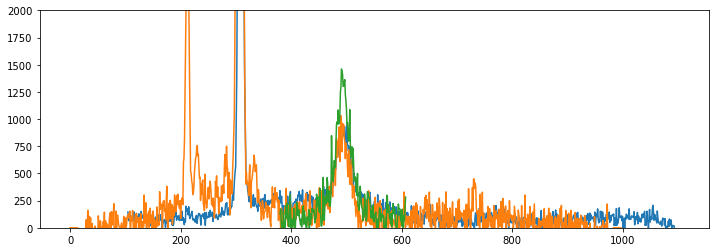

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(jslit + db["shift"], (imslit_profile + 20) * 10)
ax.plot(jslit, spec_profile)
ax.plot(jslit, calib_profile * 1000)
ax.set(yscale="linear", ylim=[0, 2000]);

That did not come out how I hoped. The calibration profile is clearly broader. To try and get to the bottom of this, I will jhave to look at some neighboring profiles

In [24]:
neighbors = [-2, -1, 1, 2]
nb_calib_profiles = {}
for nb in neighbors:
    nbdb = db.copy()
    nbdb["islit"] += nb
    nb_slit_coords = mes.find_slit_coords(nbdb, im_hdu.header, spec_hdu.header)
    nb_calib_profiles[nb] = mes.slit_profile(
        nb_slit_coords['RA'], nb_slit_coords['Dec'], photom.data, wphot
    )

iarr = [-104.5571366   -4.5571366   95.4428634  195.4428634  295.4428634
  395.4428634  495.4428634  595.4428634  695.4428634  795.4428634] jarr = [439. 439. 439. 439. 439. 439. 439. 439. 439. 439.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58489159, 43.64531574), (318.58483833, 43.65505278),
     (318.58478504, 43.66478984), (318.58473174, 43.67452689),
     (318.58467842, 43.68426394), (318.58462508, 43.69400099),
     (318.58457173, 43.70373805), (318.58451835, 43.7134751 ),
     (318.58446497, 43.72321215), (318.58441156, 43.7329492 )]>
Binning along slit: image = 2 spectrum = 2
iarr = [-104.5571366   -4.5571366   95.4428634  195.4428634  295.4428634
  395.4428634  495.4428634  595.4428634  695.4428634  795.4428634] jarr = [440. 440. 440. 440. 440. 440. 440. 440. 440. 440.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58475704, 43.64531535), (318.58470375, 43.6550524 ),
     (318.58465044, 43.66478945), (318.58459711, 43.6745265 ),

coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58448792, 43.64531458), (318.58443458, 43.65505163),
     (318.58438123, 43.66478868), (318.58432786, 43.67452573),
     (318.58427448, 43.68426278), (318.58422108, 43.69399984),
     (318.58416766, 43.70373689), (318.58411422, 43.71347394),
     (318.58406076, 43.72321099), (318.58400729, 43.73294804)]>
Binning along slit: image = 2 spectrum = 2
iarr = [-104.5571366   -4.5571366   95.4428634  195.4428634  295.4428634
  395.4428634  495.4428634  595.4428634  695.4428634  795.4428634] jarr = [443. 443. 443. 443. 443. 443. 443. 443. 443. 443.]
coords = <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(318.58435336, 43.64531419), (318.5843    , 43.65505124),
     (318.58424663, 43.66478829), (318.58419324, 43.67452534),
     (318.58413983, 43.6842624 ), (318.58408641, 43.69399945),
     (318.58403297, 43.7037365 ), (318.58397951, 43.71347355),
     (318.58392603, 43.7232106 ), (318.58387254, 43.73294765)]>
Binning 

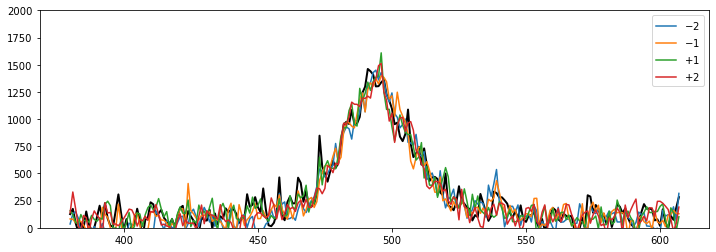

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(jslit + db["shift"], (imslit_profile + 20) * 10)
# ax.plot(jslit, spec_profile)
ax.plot(jslit, calib_profile * 1000, color="k", lw=2)
for nb in neighbors:
    ax.plot(jslit, nb_calib_profiles[nb] * 1000, label=f"${nb:+d}$")
ax.legend()
ax.set(yscale="linear", ylim=[0, 2000]);

In [26]:
slit_points = (np.arange(len(spec_profile)) - j0_s)*slit_coords["ds"]

In [27]:
jslice0 = slice(int(j0_s)-20, int(j0_s)+20)

In [28]:
rat0 = np.nansum(spec_profile[jslice0]) / np.nansum(calib_profile[jslice0])
print('Coarse calibration: ratio =', rat0)

Coarse calibration: ratio = 703.301225868086


In [29]:
spec_profile[jslice0]

array([ 140.74709,  387.12506,  402.5268 ,  424.21317,  483.02756,
        285.92334,  497.8567 ,  561.247  ,  576.6883 ,  530.9808 ,
        388.84088,  641.6171 ,  821.37714,  696.85846,  647.32074,
        796.50854,  791.78   ,  928.16144,  608.2367 ,  773.4716 ,
       1030.8035 ,  894.8416 ,  699.38385,  961.81903,  883.0658 ,
        945.9802 ,  827.0291 ,  792.03735,  635.79346,  778.28796,
        688.0961 ,  676.5914 ,  536.6583 ,  471.11993,  719.24603,
        591.4495 ,  401.27655,  574.6214 ,  397.33975,  631.3194 ],
      dtype=float32)

In [30]:
calib_profile[jslice0]

array([0.19642773, 0.2217402 , 0.31188441, 0.84742553, 0.56365188,
       0.50296988, 0.42442825, 0.52026947, 0.61830886, 0.55087761,
       0.59430973, 0.777411  , 0.94851073, 0.97501777, 0.95553282,
       1.08394405, 0.95545479, 0.95928381, 1.0198297 , 1.24221541,
       1.29692915, 1.46091499, 1.43997736, 1.40913551, 1.30052089,
       1.30274616, 1.33754902, 1.36258345, 1.22740276, 1.17062284,
       1.09649022, 0.95289372, 0.96744347, 0.83850651, 0.7972373 ,
       0.86229259, 1.08736064, 0.77370438, 0.65057335, 0.68344104])

In [31]:
spec_profile /= rat0

In [32]:
figpath = Path.cwd().parent / "figs"
figpath.mkdir(exist_ok=True)

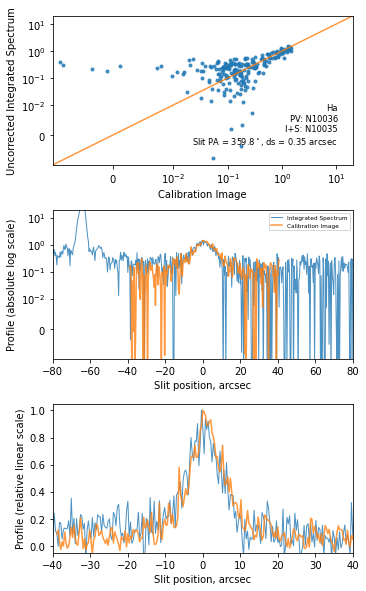

In [33]:
plt_prefix = figpath / f"{db['slit_id']}-calib"
mes.make_three_plots(
    spec_profile, 
    calib_profile, 
    plt_prefix,
    slit_points=slit_points,
    neighbors=None,
    db=db, 
    sdb=slit_coords,
    return_fig=True,
);